In [4]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

#from cs231n.classifiers.neural_net import TwoLayerNet

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [5]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

class TwoLayerNet(object):
    """
  A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer.
  In other words, the network has the following architecture:
  input - fully connected layer - ReLU - fully connected layer - softmax
  The outputs of the second fully-connected layer are the scores for each class.
  """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        
        """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:
    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)
    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
      """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
    Compute the loss and gradients for a two layer fully connected neural
    network.
    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.
    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].
    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

    # Compute the forward pass
        scores = None
    
    # Perform the forward pass, computing the class scores for the input. #
    # Store the result in the scores variable, which should be an array of      #
    # shape (N, C).                                                             #
  
        a1 = X@W1
        h1 = a1+b1
        out1 = h1.clip(min=0)

        a2 = out1@W2
        h2 = a2+b2

        scores = h2
    
    # If the targets are not given then jump out, we're done
        if y is None:
            return scores

    # Compute the loss
        loss = None
   
    #  Finish the forward pass, and compute the loss. This should include  #
    # both the data loss and L2 regularization for W1 and W2. Store the result  #
    # in the variable loss, which should be a scalar. Use the Softmax           #
    # classifier loss.                                                          #
   
        num_examples = scores.shape[0]
        exped = np.exp(scores)
        exp_sum = np.sum(exped, 1).reshape((-1,1))
        all_scores = exped/exp_sum
        right_class_scores = all_scores[np.arange(num_examples), y];
        loss = -np.sum(np.log(right_class_scores))/num_examples
        loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
        
    # Backward pass: compute gradients
        grads = {}
   
    # Compute the backward pass, computing the derivatives of the weights #
    # and biases. Store the results in the grads dictionary. For example,       #
    # grads['W1'] should store the gradient on W1, and be a matrix of same size #
    
        all_scores[np.arange(num_examples), y] -= 1
        dh2 = all_scores/num_examples

        db2 = np.sum(dh2, axis=0)
        grads['b2'] =db2
        da2 = dh2

        dW2 = out1.T@da2 +2*W2*reg
        grads['W2']=dW2

        dout1 = da2@W2.T
        dh1 = dout1
        dh1[out1==0] = 0

        db1 = np.sum(dh1, axis=0)
        grads['b1'] =db1
        da1 = dh1

        dW1 = X.T@da1 +2*W1*reg
        grads['W1']=dW1


        return loss, grads
    
    
    def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
        
        """
    Train this neural network using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

      # Create a random minibatch of training data and labels, storing  #
      # them in X_batch and y_batch respectively.                             #
            idx = np.random.randint(num_train, size=batch_size)
            X_batch = X[idx]
            y_batch = y[idx]
     

      # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)
            
            for param in self.params:
                self.params[param]-= learning_rate * grads[param]
            
            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))
            
            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:          
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                
                # Decay learning rate
                learning_rate *= learning_rate_decay
                
        return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

    def predict(self, X):
        
        """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.
    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.
    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
        y_pred = None

    
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
    
        a1 = X@W1
        h1 = a1+b1
        out1 = h1.clip(min=0)

        a2 = out1@W2
        h2 = a2+b2
        y_pred = np.argmax(h2, axis=1)
    
        return y_pred
    


In [6]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

In [7]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027209324e-08


In [8]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.79412040779e-13


In [9]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 4.447677e-11
W2 max relative error: 3.440708e-09
b1 max relative error: 2.738421e-09
W1 max relative error: 3.669858e-09


Final training loss:  0.0171496079387


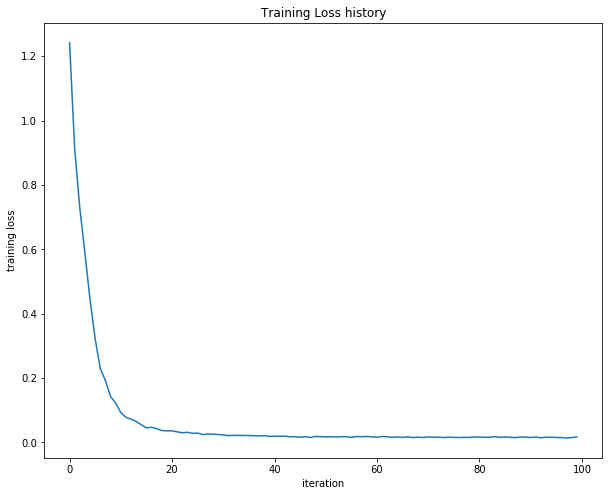

In [10]:
import matplotlib.pyplot as plt
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

In [11]:
from cs231n.data_utils import load_CIFAR10
import numpy as np

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


In [12]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# predict on validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('validation accuracy:', val_acc)


iteration 0 / 1000: loss 2.302954
iteration 100 / 1000: loss 2.302550
iteration 200 / 1000: loss 2.297648
iteration 300 / 1000: loss 2.259602
iteration 400 / 1000: loss 2.204170
iteration 500 / 1000: loss 2.118565
iteration 600 / 1000: loss 2.051535
iteration 700 / 1000: loss 1.988466
iteration 800 / 1000: loss 2.006591
iteration 900 / 1000: loss 1.951473
validation accuracy: 0.287


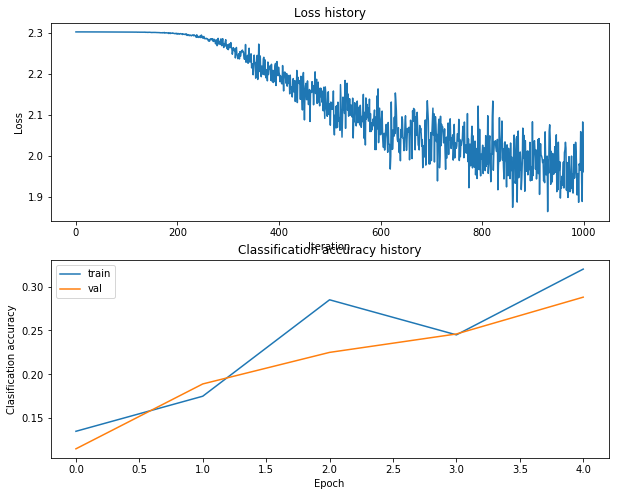

In [13]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

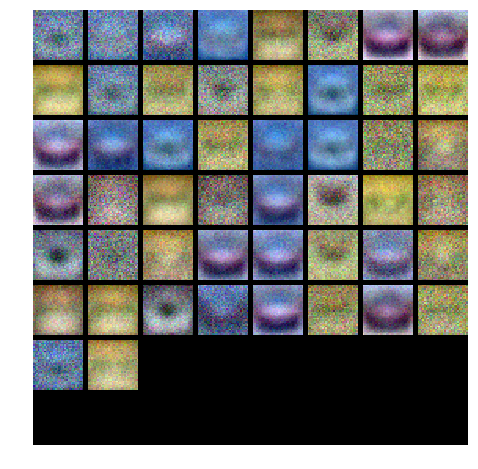

In [14]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

In [15]:
best_net = None # store the best model into this 

input_size = 32 * 32 * 3
hidden_size = 100
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=8000, batch_size=64,
            learning_rate=2e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()

iteration 0 / 8000: loss 2.303413
iteration 100 / 8000: loss 2.292661
iteration 200 / 8000: loss 2.178010
iteration 300 / 8000: loss 2.036622
iteration 400 / 8000: loss 2.067205
iteration 500 / 8000: loss 1.920506
iteration 600 / 8000: loss 1.871370
iteration 700 / 8000: loss 1.824874
iteration 800 / 8000: loss 1.734936
iteration 900 / 8000: loss 1.737213
iteration 1000 / 8000: loss 1.711177
iteration 1100 / 8000: loss 1.617336
iteration 1200 / 8000: loss 1.764696
iteration 1300 / 8000: loss 1.709594
iteration 1400 / 8000: loss 1.482753
iteration 1500 / 8000: loss 1.619394
iteration 1600 / 8000: loss 1.845229
iteration 1700 / 8000: loss 1.781231
iteration 1800 / 8000: loss 1.596831
iteration 1900 / 8000: loss 1.590345
iteration 2000 / 8000: loss 1.647443
iteration 2100 / 8000: loss 1.376299
iteration 2200 / 8000: loss 1.512766
iteration 2300 / 8000: loss 1.380006
iteration 2400 / 8000: loss 1.689050
iteration 2500 / 8000: loss 1.698826
iteration 2600 / 8000: loss 1.469264
iteration 270

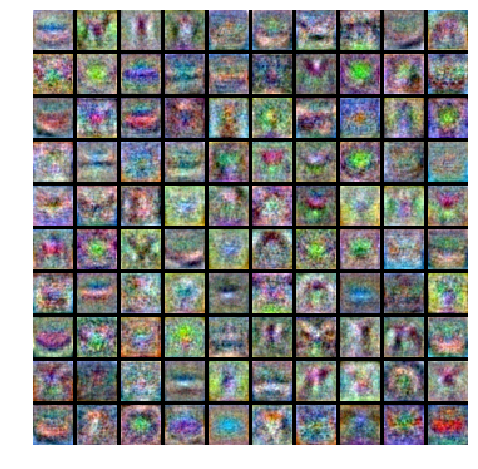

In [18]:
# visualize the weights of the best network
best_net = net
show_net_weights(best_net)

In [19]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.511
